In [23]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
%matplotlib inline
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists("save_image"):
    os.mkdir("save_image")
if not os.path.exists("dataset"):
    os.mkdir("dataset")
if not os.path.exists("asset"):
    os.mkdir("asset")


mnist_train=MNIST("dataset",train=True,download=True, transform=transforms.ToTensor())
mnist_test=MNIST("dataset",train=False,download=True, transform=transforms.ToTensor())
train_loader=DataLoader(mnist_train,batch_size=32,shuffle=True)
test_loader=DataLoader(mnist_test,batch_size=32,shuffle=False)


print(len(train_loader)) #60000/batch_size
print(len(test_loader)) #10000/batch_size

1875
313


Text(0.5,1,'Label=1')

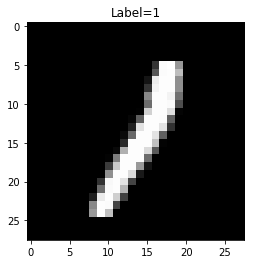

In [24]:
data_iter=iter(train_loader)
images,labels=data_iter.next()
image=images[0].numpy() #(1,28,28)
image=image.reshape(28,28)
plt.imshow(image,cmap="gray")
plt.title("Label={}".format(labels[0]))


In [25]:
class Encoder(nn.Module):
    def __init__(self,input_channels,hidden_size):
        super(Encoder,self).__init__()
        self.input_channels=input_channels
        self.hidden_size=hidden_size
        #(1,28,28)
        self.encode=nn.Sequential(

            nn.Conv2d(self.input_channels,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #(16,14,14)

            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #(32,7,7)

            nn.Conv2d(32,64,kernel_size=2,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            #(64,4,4)
        
        self.mean=nn.Sequential(
            nn.Linear(64*4*4,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,hidden_size))       
        self.logvar=nn.Sequential(
            nn.Linear(64*4*4,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,hidden_size))
            
    def forward(self,x):
        batch_size=x.size()[0]
        encoding=self.encode(x)
        mean=self.mean(encoding.view(batch_size,-1))
        logvar=self.logvar(encoding.view(batch_size,-1))
        
        return mean,logvar
    
    def encode_layer(self,x):
        batch_size=x.size()[0]
        output=self.encode(x)
        
        return output
        


In [26]:
test_input=torch.ones(32,1,28,28)
encoder=Encoder(1,32)

m,v=encoder(test_input)

print(m.size(),v.size())

torch.Size([32, 32]) torch.Size([32, 32])


In [27]:
class Decoder(nn.Module):
    def __init__(self,hidden_size):
        super(Decoder,self).__init__()
        self.hidden_size=hidden_size
        
        self.pre=nn.Sequential(
            nn.Linear(hidden_size,64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU())
        
        self.decode=nn.Sequential(
            #(64,4,4)
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #(32,7,7)
            
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            #(16,14,14)
            
            nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            #(8,28,28),
            
            nn.ConvTranspose2d(8,1,kernel_size=3,stride=1,padding=1),
            nn.Sigmoid())
        
    def forward(self,code):
        preprocess=self.pre(code)
        preprocess=preprocess.view(-1,64,4,4)
            
        out=self.decode(preprocess)
        return out
            
        
        


In [28]:
test1=torch.ones(32,32)


decoder=Decoder(32)
out=decoder(test1)        
out.size()     
            
            

torch.Size([32, 1, 28, 28])

In [29]:
class VAE(nn.Module):
    def __init__(self,input_channels,hidden_size):
        super(VAE,self).__init__()
        self.input_channles=input_channels
        self.hidden_size=hidden_size
        self.encoder=Encoder(input_channels,hidden_size)
        self.decoder=Decoder(hidden_size)
        
    def forward(self,x):
        batch_size=x.size()[0]
        mean,logvar=self.encoder(x)
        std=logvar.mul(0.5).exp_()
        
        noise=torch.randn((batch_size,self.hidden_size))
        if cuda:
            noise=noise.cuda()
        noise=mean+std*noise
            
        decode_image=self.decoder(noise)
        decode_image=decode_image.view(-1,784)
        
        return mean,logvar,decode_image
        
    

In [19]:
test_input=torch.ones(32,1,28,28)
if cuda:
    test_input=test_input.cuda()
vae=VAE(1,32)

mean,logvar,image=vae(test_input)

image.size()

torch.Size([32, 784])

In [20]:
def vae_loss(input_image,decode_image,mean,logvar):
    reconstruction_loss=F.binary_cross_entropy(decode_image,input_image.view(-1,784),size_average=False)
    kld_loss=-0.5*torch.sum(1+logvar-mean.pow(2)-logvar.exp())
    
    loss=reconstruction_loss+kld_loss
    
    return loss
    

In [21]:
model=VAE(1,32)
if cuda:
    model.cuda()
optimizer=optim.Adam(model.parameters(),lr=1e-3)


In [22]:
def train(epoch):
    model.train()
    train_loss=0
    for batch_idx,(data, _) in enumerate(train_loader):
        if cuda:
            data=V(data.cuda())
        else:
            data=V(data)
        optimizer.zero_grad()
        mean,logvar,decode_image=model(data)
        loss=vae_loss(data,decode_image,mean,logvar)
        loss.backward()
        train_loss+=loss.data[0]
        optimizer.step()
        
    train_loss/=len(train_loader.dataset)
    
    return train_loss

def test(epoch):
    model.eval()
    test_loss=0
    for batch_idx,(data, _) in enumerate(test_loader):
        if cuda:
            data=V(data.cuda(),valatile=True)
        else:
            data=V(data,volatile=True)
        mean,logvar,decode_image=model(data)
        loss=vae_loss(data,decode_image,mean,logvar)
        test_loss+=loss.data[0]
        
        if epoch%10==0:
            if batch_idx==0:
                n=8
                comparison=torch.cat([data[:n],decode_image.view(32,1,28,28)[:n]])
                
                save_image(comparison.data.cpu(),
                          "save_image/vae_image{}.png".format(epoch),nrow=n)
    test_loss/=len(test_loader.dataset)
    
    return test_loss

loss_list = []
test_loss_list = []
num_epochs=100
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save('asset/loss_list.npy', np.array(loss_list))
np.save('asset/test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), 'assert/vae.pth')
                
        

/Users/sasakianmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


KeyboardInterrupt: 